## First Impressions Bayesian Deep Learning

#### How does Laplace Approximation work in determining accuracy of facial impressions?

What is the probability that a synthetically generated fMRI image in reponse to some visual stimuli is an accurate representation of a true fMRI image in response to some visual stimuli?

How can laplace help?

In [3]:
#import libraries
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
import glob as glob

from PIL import Image
from matplotlib import image

In [4]:
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D
from keras.layers import Conv2D
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from sklearn import metrics

In [5]:
import torch
from torch.utils.data import Dataset,DataLoader, TensorDataset
from torchvision import transforms
import torch.distributions as dists
from torch.utils import data


In [6]:
from torchsummary import summary

In [7]:
import torch.distributions as dists
import numpy as np
import helper.wideresnet as wrn
import helper.dataloaders as dl
from helper import util
from netcal.metrics import ECE

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D
from keras.layers import Conv2D
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from sklearn import metrics

### Prepping the image data

In [9]:
#function for splitting array into 2 column array
def split_odd_even(df,col_name1, col_name2):
    even = df.loc[::2]
    even = even.reset_index(drop=True)
    even.columns = [col_name1]
    
    odd = df.loc[1::2]
    odd = odd.reset_index(drop=True)
    odd.columns = [col_name2]
    
    split_df = pd.concat([even,odd], axis = 1)
    
    return split_df

In [10]:
#Image directory path
img_folder = 'C:\\Users\\hinds\\CSResearch\\Data\\Image'

#Reading images and filenames into array
def create_dataset_PIL(img_folder):
    img_data_array = []
    for file in os.listdir(os.path.join(img_folder)):
        img_data_array.append(file)
        image_path = os.path.join(img_folder,  file)
        imgPre = Image.open(image_path)
        img = np.array(imgPre.resize((224, 224)))
        
        img = np.repeat(img[..., np.newaxis], 3, -1)
        img = img.astype('float32')
        img /= 255
        img_data_array.append(img)
        
    img_arr = pd.DataFrame(img_data_array)
    img_arr = img_arr.astype(object)
    #img_arr.columns = ["Image", "FileName"]
    
    return img_arr

#Array of files and images
img_arr = create_dataset_PIL(img_folder)

In [11]:
# test_img = 'C:\\Users\\hinds\\CSResearch\\Data\\Image\\face10001id49642.jpg'
# data1 =  np.array(Image.open(test_img))
# rgb_batch = np.repeat(data1[..., np.newaxis], 3, -1)
# rgb_batch.shape

In [12]:
#Seperating file and image
img_df = split_odd_even(img_arr, "FileName", "Image")

In [13]:
#Directory for annotations
annotations_folder = 'C:\\Users\\hinds\\CSResearch\\Data\\Annotation'

#functions for reading annotations to multidimensional array
def get_annotations(path):
    os.chdir(path)
    all_files = glob.glob(path)

    li = []

    for filename in os.listdir()[1:]:
        df = pd.read_csv(filename, index_col=None, header=None)
        li.append(df)
        
    return li

ann_arr = get_annotations(annotations_folder)

In [14]:
#Function for creating data frame splitting training, testing and validation sets
def make_ann_df(arr):
    #seperate testing, index 0-3
    testing = pd.concat([arr[0],arr[1], arr[2], arr[3]], axis = 1)
    testing.columns = ["TestFile1", "Age","TestFile2", "Dominance","TestFile3", "IQ","TestFile4", "Trustworthiness"]
    
    #seperate training, index 4-7
    training = pd.concat([arr[4],arr[5], arr[6], arr[7]], axis = 1)
    training.columns = ["TrainFile1", "Age","TrainFile2", "Dominance","TrainFile3", "IQ","TrainFile4", "Trustworthiness"]
    
    #seperate validation, index 8-11
    validation = pd.concat([arr[8],arr[9], arr[10], arr[11]], axis = 1)
    validation.columns = ["ValFile1", "Age","ValFile2", "Dominance","ValFile3", "IQ","ValFile4", "Trustworthiness"]
    
    return testing, training, validation

testing,training,validation = make_ann_df(ann_arr)


In [15]:
#function for matching images with their respective features.
def make_image_ann_df(image,ann,ttv):
    merged_df = pd.merge(image, ann, left_on="FileName", right_on= ttv + "File1", how="inner")
    merged_df = merged_df.drop([ttv+'File1', ttv+'File2',ttv+'File3',ttv+'File4'], axis=1)
    return merged_df

In [16]:
#Create sets

#test set
test = make_image_ann_df(img_df,testing,"Test").dropna()

#train set
train = make_image_ann_df(img_df,training,"Train").dropna()

#validation set
validate = make_image_ann_df(img_df,validation,"Val").dropna()

In [17]:
train.head()

,FileName,Image,Age,Dominance,IQ,Trustworthiness
0,face10000id49641.jpg,"[[[0.9098039, 0.9098039, 0.9098039], [0.909803...",3.523810,0.576389,4.166667,0.420398
1,face10001id49642.jpg,"[[[0.5568628, 0.5568628, 0.5568628], [0.556862...",4.066667,0.468137,3.631579,0.246377
2,face10002id49643.jpg,"[[[0.40392157, 0.40392157, 0.40392157], [0.349...",1.500000,0.303030,3.833333,0.555556
3,face10005id49646.jpg,"[[[0.7058824, 0.7058824, 0.7058824], [0.705882...",1.000000,0.230769,2.750000,0.727273
4,face10006id49647.jpg,"[[[0.043137256, 0.043137256, 0.043137256], [0....",1.550000,0.275000,4.200000,0.558824


In [18]:
def train_test_val_set(train,test,val,response):
    x_train,y_train = train['Image'].values,train[response].values
    x_train = np.array([val for val in x_train])
    y_train = np.array([val for val in y_train])
    
    x_test,y_test = test['Image'].values,test[response].values
    x_test = np.array([val for val in x_test])
    y_test = np.array([val for val in y_test])
    
    x_validate,y_validate = val['Image'].values,val[response].values
    x_validate = np.array([val for val in x_validate])
    y_validate = np.array([val for val in y_validate])
    
    return x_train, y_train, x_test, y_test, x_validate, y_validate

In [19]:
#Set which response value you want to predict: Age, Dominance, IQ, Trustworthiness
response = "Age"
x_train, y_train, x_test, y_test, x_validate, y_validate = train_test_val_set(train,test,validate,response)

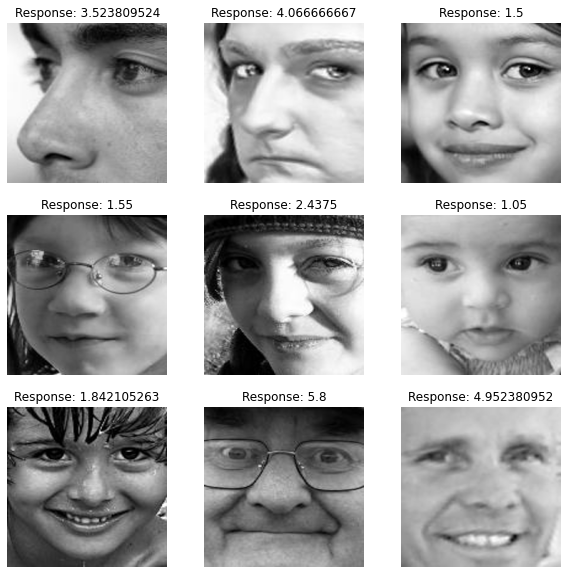

In [20]:
#Viewing images with their response value
fig, axes = plt.subplots(3, 3, figsize=(10,10))

for i in range(3):
    for j in range(3):
        axes[i,j].imshow(x_train[i*4 + j])
        axes[i,j].set_title("Response"+": " + str(y_train[i*4+j]))
        axes[i,j].axis('off')

plt.show()

#### Make train loader

In [21]:
batch_size = 64

In [22]:
#How to improve this?

train_target = torch.tensor(train[response]).float()

In [23]:
train1 = torch.tensor(train['Image']).float()

<ipython-input-23-bb52f6f26a7c>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  train1 = torch.tensor(train['Image']).float()


In [24]:
train1 = train1.permute(0,3,1,2)
train_tensor = TensorDataset(train1, train_target)

In [134]:
train_loader = DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

In [24]:
# test_target = torch.tensor(test[response])
# test1 = torch.tensor(test['Image'])
# test1 = test1.permute(0,3,1,2)
# test_tensor = TensorDataset(test1, test_target) 
# test_loader = DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

In [25]:
#pretrained model

#Dont use dont jon
#model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)

In [99]:
# train_target = train_target.double
# train1 = train1.double

AttributeError: 'builtin_function_or_method' object has no attribute 'double'

All in related work section. Nates papers.

In [128]:
#Making sure data loader is correct. 

train_iter = iter(train_loader)
print(type(train_iter))


images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([64, 224, 224, 3])
labels shape on batch size = torch.Size([64])


#### LAPLACE STUFF

In [2]:
sample_train = train.sample(n=10,ignore_index = True)

sample_train

NameError: name 'train' is not defined

In [1]:
sample_train[Image]

NameError: name 'sample_train' is not defined

In [219]:
train_target = torch.tensor(sample_train[response].values.reshape(-1,1)).float()
train_input = torch.tensor(sample_train['Image']).float()
train_input = train_input.permute(0,3,1,2)

train_tensor = TensorDataset(train_input, train_target)
train_loader = DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

In [220]:
train_iter1 = iter(train_loader)
print(type(train_iter))


images, labels = train_iter1.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([10, 3, 224, 224])
labels shape on batch size = torch.Size([10, 1])


In [37]:
import torch.nn as nn

In [38]:
from laplace import Laplace
import torchvision.models as models


In [39]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

In [225]:
# model = wrn.WideResNet(16, 4, num_classes=10).eval()
# #model = CNN(batch_size = batch_size)

# util.download_pretrained_model()
# model.load_state_dict(torch.load('./temp/CIFAR10_plain.pt',map_location=torch.device('cpu')))


#torch.Size: [64, 3, 224, 224] for 4938 total obervations
# model = torch.nn.Sequential(
#     nn.Linear(224, 10),
#     nn.Linear(10, 2048),
#     nn.LeakyReLU(0.2),
#     nn.Linear(2048, 512),
#     nn.LeakyReLU(0.2),
#     nn.Linear(512, 64)
# )

model =  torch.nn.Sequential (
    torch.nn.Linear(224,224), 
    torch.nn.Tanh(), 
    torch.nn.Linear(224, 224)
)

In [226]:
summary(model,(10,3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1      [-1, 10, 3, 224, 224]          50,400
              Tanh-2      [-1, 10, 3, 224, 224]               0
            Linear-3      [-1, 10, 3, 224, 224]          50,400
Total params: 100,800
Trainable params: 100,800
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 5.74
Forward/backward pass size (MB): 34.45
Params size (MB): 0.38
Estimated Total Size (MB): 40.58
----------------------------------------------------------------


In [227]:

la = Laplace(model, 'regression',
             subset_of_weights='last_layer',
             hessian_structure='diag')

difference between regressor and classifer, for classifer the laster layer is softmax
convlutions are just based off images are 

classifer is expected to be mutli output, 

regression is just 


usually dea lwith small samples sizes. 
it's very noisy, coco the image labels, cluster groups of images and super classes, and group responses together. 

given sample and trials and noise 

justifing significant results given the noise, signal to noise ratio to justify, noisy in same as original?      

two class problem. 

can we do this to improve the robustness of a cifar10 data using brain data. 

In [217]:
import torch.utils.data as data_utils

def get_sinusoid_example(n_data=150, sigma_noise=0.3, batch_size=150):
    # create simple sinusoid data set
    X_train = (torch.rand(n_data) * 8).unsqueeze(-1)
    y_train = torch.sin(X_train) + torch.randn_like(X_train) * sigma_noise
    train_loader = data_utils.DataLoader(
        data_utils.TensorDataset(X_train, y_train), 
        batch_size=batch_size
    )
    X_test = torch.linspace(-5, 13, 500).unsqueeze(-1)
    return X_train, y_train, train_loader, X_test
    
X_train, y_train, train_loader, X_test = get_sinusoid_example()

X_train.size()

torch.Size([150, 1])

In [228]:
crit = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.1)

for X,y in iter(train_loader):
    loss = crit(model(X), y)
    loss.backward()
    opt.step()

#evaluating already trained model. 

C:\Users\hinds\anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10, 3, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (224) must match the size of tensor b (10) at non-singleton dimension 2

In [139]:
# #Training a MAP
# n_epochs = 1

# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# for i in range(n_epochs):
#     for X, y in iter(train_loader):
#         optimizer.zero_grad()
#         loss = criterion(model(X), y)
#         loss.backward()
#         optimizer.step()

KeyboardInterrupt: 

In [200]:

la.fit(train_loader)
#la.optimize_prior_precision(method='marglik')


ValueError: Only 2D inputs are currently supported for MSELoss.

In [ ]:
#la.optimize_prior_precision(method='CV', val_loader=val_loader)

In [ ]:
def predict(dataloader, model, laplace=False):
    py = []

    for x, _ in dataloader:
        if laplace:
            py.append(model(x))
        else:
            py.append(torch.softmax(model(x), dim=-1))

    return torch.cat(py).cpu().numpy()

In [ ]:
probs_laplace = predict(test_loader, la, laplace=True)
acc_laplace = (probs_laplace.argmax(-1) == targets).mean()
ece_laplace = ECE(bins=15).measure(probs_laplace.numpy(), targets.numpy())
nll_laplace = -dists.Categorical(probs_laplace).log_prob(targets).mean()

print(f'[Laplace] Acc.: {acc_laplace:.1%}; ECE: {ece_laplace:.1%}; NLL: {nll_laplace:.3}')

In [ ]:
probs_laplace

In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import torch
import torch.distributions as dists
import numpy as np
import helper.wideresnet as wrn
import helper.dataloaders as dl
from helper import util
from netcal.metrics import ECE

from laplace import Laplace


np.random.seed(7777)
torch.manual_seed(7777)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

train_loader = dl.CIFAR10(train=True)
test_loader = dl.CIFAR10(train=False)
targets = torch.cat([y for x, y in test_loader], dim=0).cpu()

# The model is a standard WideResNet 16-4
# Taken as is from https://github.com/hendrycks/outlier-exposure
model = wrn.WideResNet(16, 4, num_classes=10).eval()

util.download_pretrained_model()
model.load_state_dict(torch.load('./temp/CIFAR10_plain.pt',map_location=torch.device('cpu')))

@torch.no_grad()
def predict(dataloader, model, laplace=False):
    py = []

    for x, _ in dataloader:
        if laplace:
            py.append(model(x))
        else:
            py.append(torch.softmax(model(x, dim=-1)))

    return torch.cat(py)


probs_map = predict(test_loader, model, laplace=False)
acc_map = (probs_map.argmax(-1) == targets).float().mean()
ece_map = ECE(bins=15).measure(probs_map.numpy(), targets.numpy())
nll_map = -dists.Categorical(probs_map).log_prob(targets).mean()

print(f'[MAP] Acc.: {acc_map:.1%}; ECE: {ece_map:.1%}; NLL: {nll_map:.3}')

# Laplace
la = Laplace(model, 'classification',
             subset_of_weights='last_layer',
             hessian_structure='kron')
la.fit(train_loader)
la.optimize_prior_precision(method='marglik')

probs_laplace = predict(test_loader, la, laplace=True)
acc_laplace = (probs_laplace.argmax(-1) == targets).float().mean()
ece_laplace = ECE(bins=15).measure(probs_laplace.numpy(), targets.numpy())
nll_laplace = -dists.Categorical(probs_laplace).log_prob(targets).mean()

print(f'[Laplace] Acc.: {acc_laplace:.1%}; ECE: {ece_laplace:.1%}; NLL: {nll_laplace:.3}')